In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.utils import to_categorical
from keras import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [12]:
data= pd.read_csv('1L_samples_rows.csv',header = None)
data = data[0:100000]
label = data[0]
label = label.replace(-1,0)
data = data.drop(0,axis=1)
data.shape

(100000, 114)

In [13]:
data.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114
0,0,0,0,0.053942,0.082759,0.176471,0,0,0,0,0.000000,0,0,0,0,0.0,0.000000,0.000000,0.000000,0,0.005951,0.071429,0.000000,1,1,0,0,1,0,0.0,0,0,0.000000,0,0.0,0,0,0,0.0,0,...,0.0,0,0.0,0,0.000000,0,0.00,1,0.000000,1,0,1,0,1,0.0,0,0.0,1,0,0,0,0,0,0,0.0,0,0.0,1,0.0,1,0,1,0,1,0,0,0,1,0,0
1,0,1,0,0.091286,0.144828,0.117647,0,0,0,0,0.285714,0,0,0,0,0.0,0.684713,0.764250,0.391573,0,0.285713,0.011905,0.000000,1,0,0,0,1,0,0.0,0,0,0.000000,0,0.0,0,0,0,0.0,0,...,0.0,1,0.0,0,0.000000,0,0.00,1,0.000000,1,0,1,0,1,0.0,1,0.0,1,0,1,0,1,0,0,0.0,0,0.0,1,0.0,1,0,1,0,1,0,1,0,1,0,0
2,0,1,0,0.020747,0.034483,0.058824,0,0,0,0,0.857143,0,0,0,0,0.0,0.914085,0.844078,0.198296,0,0.005951,0.005952,0.000000,0,0,0,0,0,0,0.0,0,0,0.055556,0,0.2,0,0,0,0.0,0,...,0.0,0,0.0,0,0.000000,0,0.00,1,0.333333,1,0,1,0,1,0.0,0,0.0,1,0,0,0,0,0,0,0.0,0,0.0,1,0.5,1,0,1,0,1,0,0,0,1,0,0
3,0,0,0,0.045643,0.075862,0.117647,0,0,0,0,0.000000,0,0,0,0,0.2,0.887821,0.838951,0.188060,0,0.142856,0.005952,0.142855,1,1,0,0,0,0,0.0,0,0,0.055556,0,0.0,0,0,0,0.0,0,...,0.0,0,0.0,0,0.000000,0,0.00,1,0.000000,1,0,1,0,1,0.0,0,0.0,1,0,0,0,0,0,0,0.0,0,0.0,1,0.0,1,0,1,0,1,0,0,0,1,0,0
4,0,1,0,0.029046,0.048276,0.058824,0,0,0,1,0.142857,0,0,0,0,0.1,0.916204,0.851070,0.206151,1,0.285713,0.142857,0.000000,0,0,0,0,0,0,0.0,0,0,0.666667,0,0.0,0,0,0,0.0,0,...,0.0,1,0.0,0,0.076923,0,0.05,1,0.000000,1,0,1,0,1,0.0,1,0.0,1,0,1,0,1,0,0,0.0,0,0.0,1,0.0,1,0,1,0,1,0,1,0,1,0,0


In [14]:
label.value_counts()

0    66336
1    33664
Name: 0, dtype: int64

In [15]:
X_train,X_test,Y_train,Y_test = train_test_split(data,label,stratify=label,random_state=42)

In [16]:
n_features = X_train.shape[1]
input_shape = (None,1,n_features)
X_train,X_test,Y_train,Y_test = np.array(X_train),np.array(X_test),np.array(Y_train),np.array(Y_test)
n_timesteps, n_features, n_outputs = 1, X_train.shape[1], 2
X_train = X_train.reshape((X_train.shape[0],1 , 1, n_features))
X_test = X_test.reshape((X_test.shape[0],1 , 1, n_features))
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [17]:
Y_test

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [18]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size = 1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(228))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dense(n_outputs,activation = 'softmax'))

In [24]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
epoch, batch_size, verbose= 50,32,1
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy','mse', 'mae',f1_m,precision_m, recall_m])
	# fit network
history = model.fit(X_train,Y_train,validation_data=(X_test, Y_test), epochs=epoch, batch_size=batch_size, verbose=verbose)
	# evaluate model


Epoch 1/50
2344/2344 [==============================] - 20s 9ms/step - loss: 0.0404 - accuracy: 0.9486 - mse: 0.0404 - mae: 0.0753 - f1_m: 0.9486 - precision_m: 0.9486 - recall_m: 0.9486 - val_loss: 0.0333 - val_accuracy: 0.9585 - val_mse: 0.0333 - val_mae: 0.0621 - val_f1_m: 0.9584 - val_precision_m: 0.9584 - val_recall_m: 0.9584
Epoch 2/50
2344/2344 [==============================] - 18s 8ms/step - loss: 0.0319 - accuracy: 0.9611 - mse: 0.0319 - mae: 0.0578 - f1_m: 0.9611 - precision_m: 0.9611 - recall_m: 0.9611 - val_loss: 0.0304 - val_accuracy: 0.9628 - val_mse: 0.0304 - val_mae: 0.0516 - val_f1_m: 0.9627 - val_precision_m: 0.9627 - val_recall_m: 0.9627
Epoch 3/50
2344/2344 [==============================] - 18s 8ms/step - loss: 0.0297 - accuracy: 0.9636 - mse: 0.0297 - mae: 0.0548 - f1_m: 0.9636 - precision_m: 0.9636 - recall_m: 0.9636 - val_loss: 0.0289 - val_accuracy: 0.9651 - val_mse: 0.0289 - val_mae: 0.0432 - val_f1_m: 0.9650 - val_precision_m: 0.9650 - val_recall_m: 0.9650
E

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

mse = history.history['mse']
val_mse = history.history['val_mse']

mae = history.history['mae']
val_mae = history.history['val_mae']

mae = history.history['mae']
val_mae = history.history['val_mae']

pr = history.history['precision_m']
val_pr = history.history['val_precision_m']

rec = history.history['recall_m']
val_rec = history.history['val_recall_m']

f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']

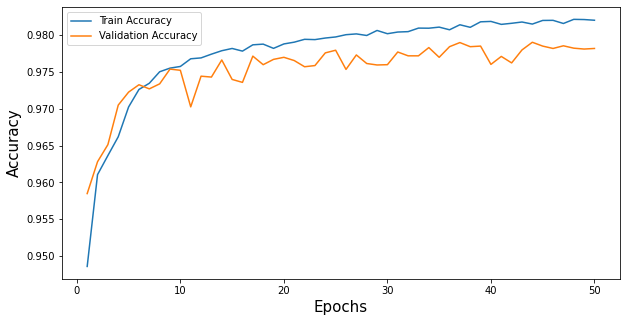

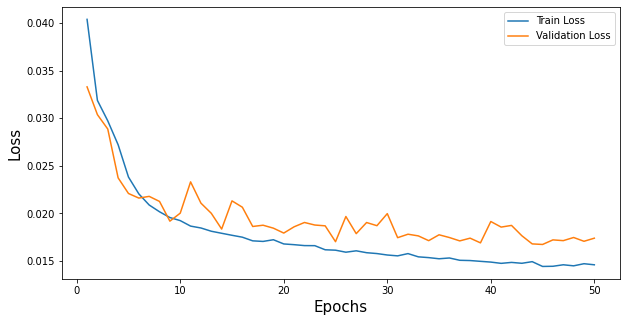

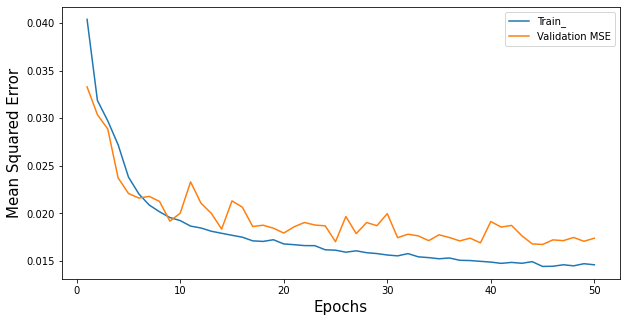

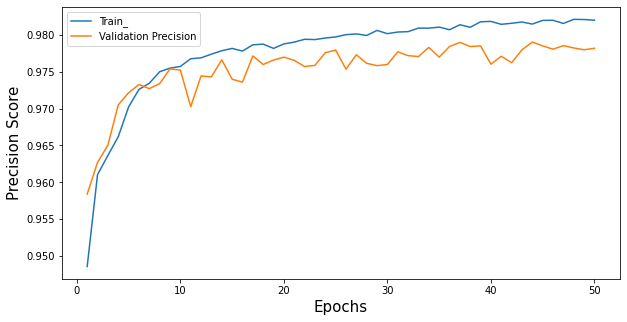

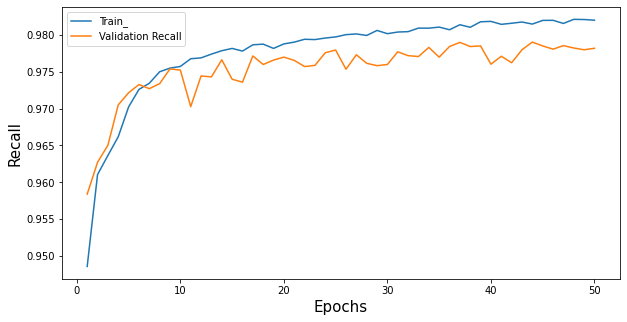

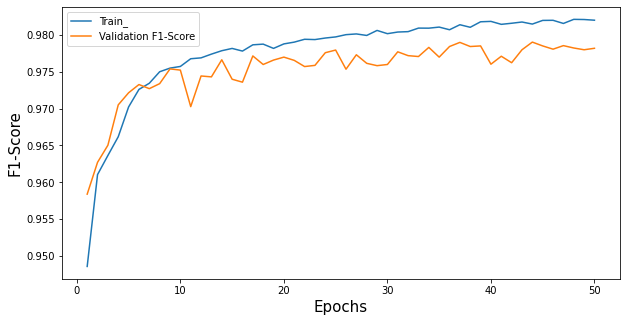

In [31]:
epochs = [i for i in range(1,epoch+1)]
plt.figure(num=1,figsize=(10,5))
plt.plot(epochs,acc,label= 'Train Accuracy')
plt.plot(epochs,val_acc,label= 'Validation Accuracy')
plt.legend()
plt.xlabel('Epochs',fontsize = 15)
plt.ylabel('Accuracy',fontsize = 15)

plt.figure(num=2,figsize=(10,5))
plt.plot(epochs,loss,label= 'Train Loss')
plt.plot(epochs,val_loss,label= 'Validation Loss')
plt.legend()
plt.xlabel('Epochs',fontsize = 15)
plt.ylabel('Loss',fontsize = 15)

plt.figure(num=3,figsize=(10,5))
plt.plot(epochs,mse,label= 'Train_')
plt.plot(epochs,val_mse,label= 'Validation MSE')
plt.legend()
plt.xlabel('Epochs',fontsize = 15)
plt.ylabel('Mean Squared Error',fontsize = 15)

plt.figure(num=4,figsize=(10,5))
plt.plot(epochs,pr,label= 'Train_')
plt.plot(epochs,val_pr,label= 'Validation Precision')
plt.legend()
plt.xlabel('Epochs',fontsize = 15)
plt.ylabel('Precision Score',fontsize = 15)

plt.figure(num=5,figsize=(10,5))
plt.plot(epochs,rec,label= 'Train_')
plt.plot(epochs,val_rec,label= 'Validation Recall')
plt.legend()
plt.xlabel('Epochs',fontsize = 15)
plt.ylabel('Recall',fontsize = 15)

plt.figure(num=6,figsize=(10,5))
plt.plot(epochs,f1,label= 'Train_')
plt.plot(epochs,val_f1,label= 'Validation F1-Score')
plt.legend()
plt.xlabel('Epochs',fontsize = 15)
plt.ylabel('F1-Score',fontsize = 15)


plt.show()